In [2]:
!pip install -U portalocker>=2.0.0 optuna-integration

## Task - 1

### PyTorch FC ANN MNIST Implementation.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import optuna
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
from optuna.integration import PyTorchLightningPruningCallback
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 64
train_val_split = 0.8

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Calculate sizes
train_size = int(train_val_split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [55]:
# Mapping the labels for the MNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [8]:
# Here we define the model parameters -- the general strucutre as provided here will produce a fully connected network [28x28] --> 32 --> 16 --> 10
class MLP(nn.Module): # MLP stands for "Multi-Layer Perceptron"
    def __init__(self, layer_sizes, activation_functions): # this initializes the structure of the network
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        input_size = 28 * 28 ## 28*28 input features and 32 outputs
        for size in layer_sizes:
            self.layers.append(nn.Linear(input_size, size))
            input_size = size
        
        self.activation_functions = activation_functions
        self.output_layer = nn.Linear(input_size, 10) ## 10 output features because MNIST has 10 target classes

    def forward(self, x): # this modifies the elements of the intial structure defined above
        x = x.view(-1, 28 * 28)  # Flatten the input
        for layer, activation in zip(self.layers, self.activation_functions):
            x = activation(layer(x))
        x = self.output_layer(x)
        return x

In [59]:
def objective(trial):
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 2, 5)
    layer_sizes = []
    activation_functions = []
    activations = {
        'relu': nn.ReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'gelu': nn.GELU(),
        'leaky_relu': nn.LeakyReLU(),
        'silu': nn.SiLU(),
    }

    optimizers = {
        'SGD': optim.SGD,
        'Adam': optim.Adam,
        'RMSprop': optim.RMSprop,
    }

    for i in range(num_layers):
        layer_size = trial.suggest_categorical(f'layer_size_{i}', [32, 64, 128, 256, 512])
        activation_name = trial.suggest_categorical(f'activation_{i}', ['relu', 'sigmoid', 'tanh', 'gelu', 'leaky_relu', 'silu'])
        layer_sizes.append(layer_size)
        activation_functions.append(activations[activation_name])

    # Suggest optimizer
    optimizer_name = trial.suggest_categorical('optimizer', ['SGD', 'Adam', 'RMSprop'])

    # Suggest learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)

    # Suggest weight decay (L2 regularization)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    # Suggest batch size
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Initialize the model
    model = MLP(layer_sizes, activation_functions)
    criterion = nn.CrossEntropyLoss()

    # Create optimizer
    optimizer_class = optimizers[optimizer_name]
    if optimizer_name == 'SGD':
        # Suggest momentum for SGD
        momentum = trial.suggest_float('momentum', 0.0, 0.9)
        optimizer = optimizer_class(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    else:
        optimizer = optimizer_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Data loaders with suggested batch size
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Training loop
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation at the end of each epoch
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total

        # Report intermediate objective value to the trial
        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [58]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=20)
print('Best hyperparameters:', study.best_params)

[I 2024-10-18 15:24:59,009] A new study created in memory with name: no-name-77e2dc11-4de9-406a-8f9b-872de8135ce5
[I 2024-10-18 15:27:12,745] Trial 0 finished with value: 0.8758333333333334 and parameters: {'num_layers': 3, 'layer_size_0': 32, 'activation_0': 'sigmoid', 'layer_size_1': 128, 'activation_1': 'tanh', 'layer_size_2': 256, 'activation_2': 'relu', 'optimizer': 'Adam', 'lr': 0.005828306766593578, 'weight_decay': 2.86220611377062e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8758333333333334.
[I 2024-10-18 15:29:29,962] Trial 1 finished with value: 0.8339166666666666 and parameters: {'num_layers': 4, 'layer_size_0': 256, 'activation_0': 'tanh', 'layer_size_1': 32, 'activation_1': 'sigmoid', 'layer_size_2': 64, 'activation_2': 'sigmoid', 'layer_size_3': 256, 'activation_3': 'tanh', 'optimizer': 'Adam', 'lr': 3.7962418963619765e-05, 'weight_decay': 0.0006165556740982419, 'batch_size': 128}. Best is trial 0 with value: 0.8758333333333334.
[I 2024-10-18 15:31:37,998] Trial

Best hyperparameters: {'num_layers': 2, 'layer_size_0': 256, 'activation_0': 'relu', 'layer_size_1': 64, 'activation_1': 'tanh', 'optimizer': 'SGD', 'lr': 0.025472423173236586, 'weight_decay': 5.754345462080459e-06, 'batch_size': 32, 'momentum': 0.5413575236280163}


In [59]:
optuna.visualization.plot_param_importances(study)

In [63]:
model = MLP([256, 64], [nn.ReLU(), nn.Tanh()]) # from best params above
# 0.002, 0.001
learning_rate = 0.025472423173236586
weight_decay = 5.754345462080459e-06
momentum = 0.5413575236280163
batch_size = 32
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

# Data loaders with suggested batch size
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training the neural network
# 3, 10, 20
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 100 == 99:  # print every 100 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {running_loss / 100}')
            running_loss = 0.0

    running_loss = 0.0  # Reset running loss
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    print(f'Validation Loss: {running_loss / len(val_loader)}')
    scheduler.step(running_loss)
    model.train()  # Set model back to training mode

print('Finished Training')

Epoch 1, Batch 100, Loss: 1.5542455327510833
Epoch 1, Batch 200, Loss: 0.783762845993042
Epoch 1, Batch 300, Loss: 0.6357443898916244
Epoch 1, Batch 400, Loss: 0.5596389240026474
Epoch 1, Batch 500, Loss: 0.5117665053904057
Epoch 1, Batch 600, Loss: 0.5017480745911598
Epoch 1, Batch 700, Loss: 0.45975630193948747
Epoch 1, Batch 800, Loss: 0.4378963331878185
Epoch 1, Batch 900, Loss: 0.43917261466383933
Epoch 1, Batch 1000, Loss: 0.3881101483851671
Epoch 1, Batch 1100, Loss: 0.36582449220120905
Epoch 1, Batch 1200, Loss: 0.35698728293180465
Epoch 1, Batch 1300, Loss: 0.36947081111371516
Epoch 1, Batch 1400, Loss: 0.32349820967763665
Epoch 1, Batch 1500, Loss: 0.32174250066280363
Validation Loss: 0.3238230610589186
Epoch 2, Batch 100, Loss: 0.30769499465823175
Epoch 2, Batch 200, Loss: 0.27163708183914426
Epoch 2, Batch 300, Loss: 0.3026940692216158
Epoch 2, Batch 400, Loss: 0.3017319418117404
Epoch 2, Batch 500, Loss: 0.2477607125788927
Epoch 2, Batch 600, Loss: 0.27852833185344933
Epoc

In [64]:
# Evaluating the model
model.eval()
correct = 0
total = 0
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}')

Accuracy on test set: 0.9738


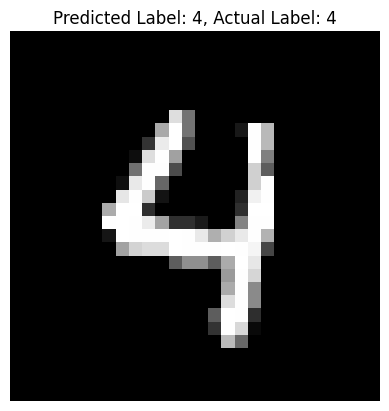

In [65]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {predicted_label.item()}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

Notes for Part 1

1. Activation function:

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))  # Change activation function here
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

2. loss function and optimizer

model = Net()
criterion = torch.nn.CrossEntropyLoss()  # Change loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

3. ~adding a dropout layer

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, 128)
        self.dropout = torch.nn.Dropout(0.2)  # Add a Dropout layer here
        self.fc2 = torch.nn.Linear(128, 64)
        self.fc3 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

4. model configurations / epochs

epochs = 10  # Change number of epochs
for epoch in range(epochs):
    # Training loop
    for i, data in enumerate(train_loader, 0):
        # Training steps

## Task - 2

### PyTorch FC ANN FMNIST Implementation


In [3]:
# Transformations --> this is a "pre-processing step" that's typical for image processing methods
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.Normalize((0.5,), (0.5,))])

train_val_split = 0.8

# This dataset is already "sorted" as part of the import method, but no "validation" set has been selected in this case
# Loading the FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Calculate sizes
train_size = int(train_val_split * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [4]:
# Mapping the labels for the FashionMNIST dataset -- later we'll see that this using the "keras to_categorical" method as discussed in class
labels_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"
}

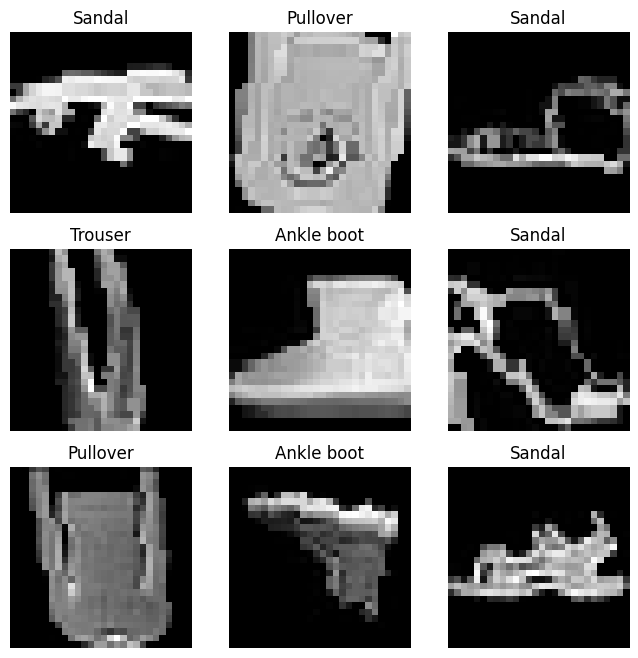

In [5]:
#This cell is designed to display a few images from the dataset
#It isn't necessary to run this, but it can help give a better idea of the challanges your model will face
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Displaying figures from the dataset randomly
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [60]:
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=30)

print('Best hyperparameters:', study.best_params)

[I 2024-10-21 15:42:13,909] A new study created in memory with name: no-name-76c6205c-d7e9-414a-9ab2-34af32a4144c
[I 2024-10-21 15:57:03,359] Trial 0 finished with value: 0.7394166666666667 and parameters: {'num_layers': 5, 'layer_size_0': 512, 'activation_0': 'sigmoid', 'layer_size_1': 128, 'activation_1': 'sigmoid', 'layer_size_2': 128, 'activation_2': 'silu', 'layer_size_3': 128, 'activation_3': 'gelu', 'layer_size_4': 512, 'activation_4': 'gelu', 'optimizer': 'RMSprop', 'lr': 0.00019716788737518756, 'weight_decay': 0.000326821966050165, 'batch_size': 128}. Best is trial 0 with value: 0.7394166666666667.
[I 2024-10-21 16:12:43,191] Trial 1 finished with value: 0.2545 and parameters: {'num_layers': 4, 'layer_size_0': 128, 'activation_0': 'tanh', 'layer_size_1': 512, 'activation_1': 'relu', 'layer_size_2': 128, 'activation_2': 'tanh', 'layer_size_3': 256, 'activation_3': 'silu', 'optimizer': 'Adam', 'lr': 0.022408285119180724, 'weight_decay': 0.0030367280453241583, 'batch_size': 32}. 

Best hyperparameters: {'num_layers': 5, 'layer_size_0': 512, 'activation_0': 'leaky_relu', 'layer_size_1': 64, 'activation_1': 'gelu', 'layer_size_2': 256, 'activation_2': 'leaky_relu', 'layer_size_3': 256, 'activation_3': 'tanh', 'layer_size_4': 64, 'activation_4': 'leaky_relu', 'optimizer': 'RMSprop', 'lr': 0.0003211015932835766, 'weight_decay': 6.128782742220545e-06, 'batch_size': 32}


In [73]:
optuna.visualization.plot_param_importances(study)

In [50]:
best_rate = 9.111332423026142e-05
learning_rates = [0.001, 0.0001, 0.00001]
print(learning_rates)

[0.001, 0.0001, 1e-05]


In [6]:
def train_config(model, train_data, val_data, optimizer, num_epochs=3, use_tqdm=True):
    # Data loaders with suggested batch size
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
    train_losses = []
    val_losses = []
    criterion = nn.CrossEntropyLoss()

    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.1,
        patience=2,
        verbose=True,
        min_lr=1e-6
    )

    # Training the neural network
    if use_tqdm:
        epochs = tqdm(range(num_epochs))
    else:
        epochs = range(num_epochs)

    for epoch in epochs:
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 mini-batches
                train_losses.append(running_loss / 100)
                running_loss = 0.0
                if not use_tqdm:
                    print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {train_losses[-1]}')

        running_loss = 0.0  # Reset running loss
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation
            for i, data in enumerate(val_loader, 0):
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        scheduler.step(running_loss)
        # Log learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Validation Loss: {running_loss / len(val_loader)}, Learning Rate: {current_lr:.6f}')
        val_losses.append(running_loss / len(val_loader))
        model.train()  # Set model back to training mode

    return train_losses, val_losses

In [31]:
learning_rates = np.logspace(-5, -1, num=10)
learning_rates

array([1.00000000e-05, 2.78255940e-05, 7.74263683e-05, 2.15443469e-04,
       5.99484250e-04, 1.66810054e-03, 4.64158883e-03, 1.29154967e-02,
       3.59381366e-02, 1.00000000e-01])

In [12]:
all_losses = []
all_val_losses = []
# first_layer_sizes = [32, 64, 128, 256, 512, 1024]
# learning_rate = 0.00017126243071531458
# best: [nn.ReLU(), nn.Sigmoid()], dropped: nn.Tanh()
# activations = [nn.ReLU(), nn.SiLU(), nn.ELU()]
best_decay_so_far = 6.128782742220545e-06
weight_decays = np.logspace(-7, -3, num=5)
for weight_decay in weight_decays:
    # Loss function and optimizer
    model = MLP([512, 64, 256, 256, 64], [nn.LeakyReLU(), nn.GELU(), nn.LeakyReLU(), nn.Tanh(), nn.LeakyReLU()])
    optimizer = optim.RMSprop(model.parameters(), lr=0.0003211015932835766, weight_decay=weight_decay)

    train_losses, val_losses = train_config(model, train_subset, val_subset, optimizer, num_epochs=10)
    
    all_losses.append(train_losses)
    all_val_losses.append(val_losses)

    print('Finished Training for decay value:', weight_decay)


 10%|█         | 1/10 [00:46<07:00, 46.75s/it]

Validation Loss: 0.7106702228387197, Learning Rate: 0.000321


 20%|██        | 2/10 [01:33<06:13, 46.71s/it]

Validation Loss: 0.6462413430213928, Learning Rate: 0.000321


 30%|███       | 3/10 [02:20<05:27, 46.75s/it]

Validation Loss: 0.5932924262682597, Learning Rate: 0.000321


 40%|████      | 4/10 [03:07<04:40, 46.81s/it]

Validation Loss: 0.5842608303229014, Learning Rate: 0.000321


 50%|█████     | 5/10 [03:53<03:53, 46.75s/it]

Validation Loss: 0.5409990511735281, Learning Rate: 0.000321


 60%|██████    | 6/10 [04:40<03:07, 46.82s/it]

Validation Loss: 0.5522206047375997, Learning Rate: 0.000321


 70%|███████   | 7/10 [05:27<02:20, 46.94s/it]

Validation Loss: 0.5331588935057322, Learning Rate: 0.000321


 80%|████████  | 8/10 [06:15<01:34, 47.21s/it]

Validation Loss: 0.5336280425389608, Learning Rate: 0.000321


 90%|█████████ | 9/10 [07:03<00:47, 47.30s/it]

Validation Loss: 0.5137516343196233, Learning Rate: 0.000321


100%|██████████| 10/10 [07:53<00:00, 47.32s/it]


Validation Loss: 0.5042142977317174, Learning Rate: 0.000321
Finished Training for decay value: 1e-06


 10%|█         | 1/10 [00:48<07:12, 48.10s/it]

Validation Loss: 0.7494317576885223, Learning Rate: 0.000321


 20%|██        | 2/10 [01:36<06:26, 48.26s/it]

Validation Loss: 0.6544753835995992, Learning Rate: 0.000321


 30%|███       | 3/10 [02:24<05:37, 48.16s/it]

Validation Loss: 0.6131693232456843, Learning Rate: 0.000321


 40%|████      | 4/10 [03:12<04:48, 48.08s/it]

Validation Loss: 0.5997854974667232, Learning Rate: 0.000321


 50%|█████     | 5/10 [04:02<04:03, 48.62s/it]

Validation Loss: 0.5762532177766164, Learning Rate: 0.000321


 60%|██████    | 6/10 [04:50<03:14, 48.72s/it]

Validation Loss: 0.5537528429826101, Learning Rate: 0.000321


 70%|███████   | 7/10 [05:40<02:26, 48.93s/it]

Validation Loss: 0.5257064646482468, Learning Rate: 0.000321


 80%|████████  | 8/10 [06:29<01:37, 48.97s/it]

Validation Loss: 0.5307119858264923, Learning Rate: 0.000321


 90%|█████████ | 9/10 [07:18<00:48, 48.94s/it]

Validation Loss: 0.5583608630895615, Learning Rate: 0.000321


100%|██████████| 10/10 [08:07<00:00, 48.71s/it]


Validation Loss: 0.5040216606855392, Learning Rate: 0.000321
Finished Training for decay value: 1.778279410038923e-06


 10%|█         | 1/10 [00:48<07:17, 48.56s/it]

Validation Loss: 0.7749093406200409, Learning Rate: 0.000321


 20%|██        | 2/10 [01:37<06:30, 48.81s/it]

Validation Loss: 0.6520744573275248, Learning Rate: 0.000321


 30%|███       | 3/10 [02:26<05:43, 49.04s/it]

Validation Loss: 0.6071478714148204, Learning Rate: 0.000321


 40%|████      | 4/10 [03:15<04:53, 48.92s/it]

Validation Loss: 0.5762890643676122, Learning Rate: 0.000321


 50%|█████     | 5/10 [04:04<04:04, 48.92s/it]

Validation Loss: 0.5618327259222666, Learning Rate: 0.000321


 60%|██████    | 6/10 [04:53<03:15, 48.79s/it]

Validation Loss: 0.5499708769321442, Learning Rate: 0.000321


 70%|███████   | 7/10 [05:42<02:26, 48.93s/it]

Validation Loss: 0.5246781694491705, Learning Rate: 0.000321


 80%|████████  | 8/10 [06:30<01:37, 48.56s/it]

Validation Loss: 0.5136812406778336, Learning Rate: 0.000321


 90%|█████████ | 9/10 [07:17<00:48, 48.32s/it]

Validation Loss: 0.5012653450965882, Learning Rate: 0.000321


100%|██████████| 10/10 [08:05<00:00, 48.54s/it]


Validation Loss: 0.511138550043106, Learning Rate: 0.000321
Finished Training for decay value: 3.162277660168379e-06


 10%|█         | 1/10 [00:47<07:08, 47.63s/it]

Validation Loss: 0.7400857988993327, Learning Rate: 0.000321


 20%|██        | 2/10 [01:35<06:20, 47.53s/it]

Validation Loss: 0.7426152731577556, Learning Rate: 0.000321


 30%|███       | 3/10 [02:22<05:32, 47.47s/it]

Validation Loss: 0.5960188544591268, Learning Rate: 0.000321


 40%|████      | 4/10 [03:10<04:45, 47.52s/it]

Validation Loss: 0.5747482202847799, Learning Rate: 0.000321


 50%|█████     | 5/10 [03:57<03:56, 47.40s/it]

Validation Loss: 0.6064400207599004, Learning Rate: 0.000321


 60%|██████    | 6/10 [04:44<03:09, 47.44s/it]

Validation Loss: 0.5550276738405228, Learning Rate: 0.000321


 70%|███████   | 7/10 [05:32<02:22, 47.45s/it]

Validation Loss: 0.5425753126144409, Learning Rate: 0.000321


 80%|████████  | 8/10 [06:19<01:34, 47.47s/it]

Validation Loss: 0.5180317168235778, Learning Rate: 0.000321


 90%|█████████ | 9/10 [07:07<00:47, 47.45s/it]

Validation Loss: 0.5145441443125407, Learning Rate: 0.000321


100%|██████████| 10/10 [07:54<00:00, 47.45s/it]


Validation Loss: 0.509024555126826, Learning Rate: 0.000321
Finished Training for decay value: 5.623413251903491e-06


 10%|█         | 1/10 [00:47<07:07, 47.46s/it]

Validation Loss: 0.7810188834667205, Learning Rate: 0.000321


 20%|██        | 2/10 [01:34<06:18, 47.31s/it]

Validation Loss: 0.6407890509764353, Learning Rate: 0.000321


 30%|███       | 3/10 [02:22<05:31, 47.38s/it]

Validation Loss: 0.6264274330536524, Learning Rate: 0.000321


 40%|████      | 4/10 [03:09<04:44, 47.40s/it]

Validation Loss: 0.5923071438074112, Learning Rate: 0.000321


 50%|█████     | 5/10 [03:57<03:57, 47.42s/it]

Validation Loss: 0.5446747327248256, Learning Rate: 0.000321


 60%|██████    | 6/10 [04:44<03:09, 47.43s/it]

Validation Loss: 0.5392938052415848, Learning Rate: 0.000321


 70%|███████   | 7/10 [05:31<02:22, 47.42s/it]

Validation Loss: 0.5186433062156042, Learning Rate: 0.000321


 80%|████████  | 8/10 [06:19<01:34, 47.47s/it]

Validation Loss: 0.5042101879517238, Learning Rate: 0.000321


 90%|█████████ | 9/10 [07:06<00:47, 47.44s/it]

Validation Loss: 0.5055508513450623, Learning Rate: 0.000321


100%|██████████| 10/10 [07:54<00:00, 47.41s/it]

Validation Loss: 0.49351706222693126, Learning Rate: 0.000321
Finished Training for decay value: 1e-05


512/1024 seems to give the best results

In [48]:
model = MLP([512, 128], [nn.ReLU(), nn.Tanh()])
optimizer = optim.Adam(model.parameters(), lr=0.0006, weight_decay=0.00016056123553795924)
train_losses, val_losses = train_config(model, train_subset, val_subset, optimizer, num_epochs=30, use_tqdm=False)

Epoch 1, Batch 100, Loss: 1.3081545346975327
Epoch 1, Batch 200, Loss: 0.9423140254616738
Epoch 1, Batch 300, Loss: 0.815935997068882
Epoch 1, Batch 400, Loss: 0.8281712657213212
Epoch 1, Batch 500, Loss: 0.7762675866484642
Epoch 1, Batch 600, Loss: 0.7798599237203598
Epoch 1, Batch 700, Loss: 0.7880303609371185
Epoch 1, Batch 800, Loss: 0.7494754737615585
Epoch 1, Batch 900, Loss: 0.7560584396123886
Epoch 1, Batch 1000, Loss: 0.7405584028363228
Epoch 1, Batch 1100, Loss: 0.7307098439335823
Epoch 1, Batch 1200, Loss: 0.7421681144833565
Epoch 1, Batch 1300, Loss: 0.7009399497509002
Epoch 1, Batch 1400, Loss: 0.7256912609934807
Epoch 1, Batch 1500, Loss: 0.684276611506939
Validation Loss: 0.6780378988186518, Learning Rate: 0.000600
Epoch 2, Batch 100, Loss: 0.6466052797436714
Epoch 2, Batch 200, Loss: 0.6895584952831268
Epoch 2, Batch 300, Loss: 0.6781314605474472
Epoch 2, Batch 400, Loss: 0.6804203292727471
Epoch 2, Batch 500, Loss: 0.6670074480772018
Epoch 2, Batch 600, Loss: 0.6860466

C:\Users\rgbmr\AppData\Local\Temp\ipykernel_8696\3062637867.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_configs)  # Get a color map with enough colors


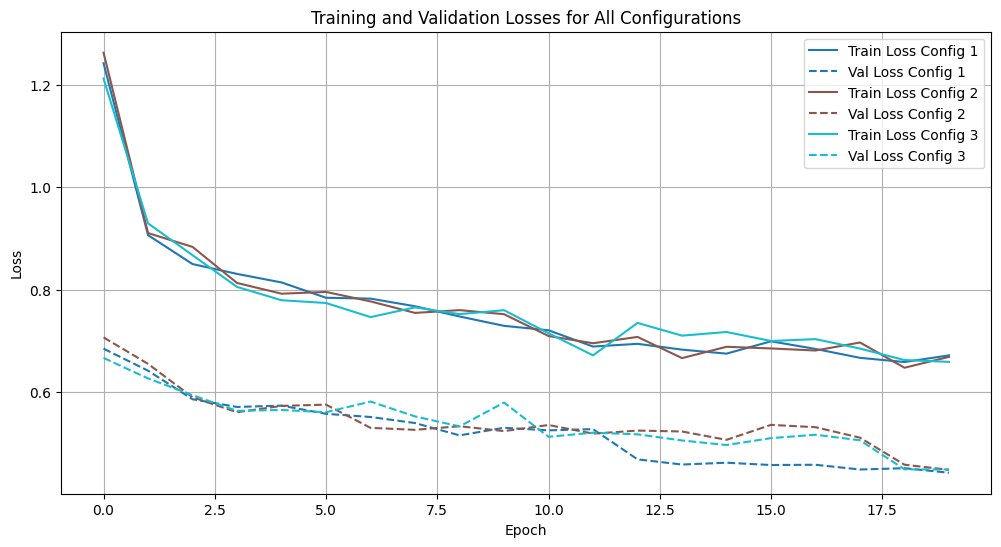

In [10]:
def plot_losses(all_train_losses, all_val_losses):
    plt.figure(figsize=(12, 6))  # Set a suitable figure size
    num_configs = len(all_train_losses)
    colors = plt.cm.get_cmap('tab10', num_configs)  # Get a color map with enough colors

    for idx, (train_losses, val_losses) in enumerate(zip(all_train_losses, all_val_losses)):
        # Use different colors for each configuration
        color = colors(idx)
        # Plot training losses with solid lines
        plt.plot(train_losses[:len(val_losses)], label=f'Train Loss Config {idx+1}', color=color, linestyle='-')
        # Plot validation losses with dashed lines
        plt.plot(val_losses, label=f'Val Loss Config {idx+1}', color=color, linestyle='--')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses for All Configurations')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(all_losses, all_val_losses)
#plot_losses([train_losses], [val_losses]) # only one configuration

In [50]:
# Evaluating the model
model.eval()
correct = 0
total = 0
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on test set: { correct / total}')

Accuracy on test set: 0.8385


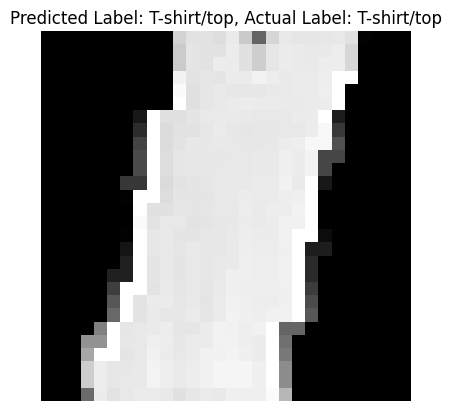

In [23]:
image_index = 27
test_image, test_label = test_dataset[image_index]

with torch.no_grad():
    model.eval()
    output = model(test_image.unsqueeze(0))
    _, predicted_label = torch.max(output, 1)

test_image_numpy = test_image.squeeze().numpy()

plt.imshow(test_image_numpy, cmap='gray')
plt.title(f'Predicted Label: {labels_map[predicted_label.item()]}, Actual Label: {labels_map[test_label]}')
plt.axis('off')
plt.show()

## PART - 3

### FMNIST CNN Implimentation with Keras

In [6]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical
import numpy as np

In [2]:
# Mapping the labels for the MNIST dataset
labels_map = {
    0: "0", 1: "1", 2: "2", 3: "3", 4: "4",
    5: "5", 6: "6", 7: "7", 8: "8", 9: "9"
}

In [3]:
# Load and preprocess the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [19]:
model = Sequential([
    Conv2D(16, (3, 3), activation='sigmoid', input_shape=(28, 28, 1)),  # 16 filters (reduced), 3x3 kernel
    MaxPooling2D(pool_size=(5, 5)),  # Max pooling with 2x2 pool size
    # Flatten the output before passing to Dense layers
    Flatten(),
    Dense(64, activation='softmax'),  # Reduced from 128 to 64 units
    Dense(10, activation='softmax')  # Output layer with 10 units for classification
])

## change the architecture with CONV2D, Pooling, and Dense.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
learning_rate = 0.01
epochs = 5
batch_size = 48

# Compile the model
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.0981 - loss: 2.3028
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.0969 - loss: 2.3024
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0964 - loss: 2.3020
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1077 - loss: 2.3015
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0918 - loss: 2.3002
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0962 - loss: 2.2981
Test accuracy: 0.10000000149011612


In [13]:
from keras.callbacks import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# Train the model with early stopping
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', accuracy)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.0951 - loss: 2.2976 - val_accuracy: 0.0782 - val_loss: 2.2944
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1121 - loss: 2.2928 - val_accuracy: 0.1810 - val_loss: 2.2860
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1941 - loss: 2.2815 - val_accuracy: 0.1964 - val_loss: 2.2593
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2090 - loss: 2.2439 - val_accuracy: 0.2071 - val_loss: 2.1862
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2047 - loss: 2.1652 - val_accuracy: 0.2084 - val_loss: 2.1000
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2142 - loss: 2.0979
Test accuracy: 0.2093999981880188


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


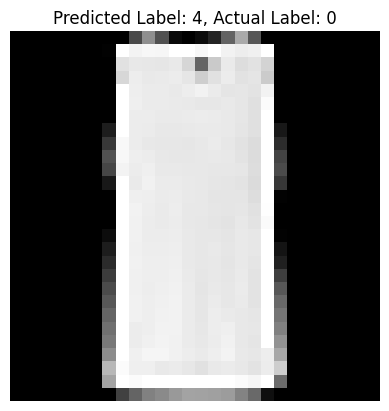

In [18]:
image_index = 27

# Extract the test image and label
test_image = x_test[image_index]
test_label = np.argmax(y_test[image_index])

# Reshape the test image for prediction (Keras expects a batch dimension)
test_image_reshaped = np.expand_dims(test_image, axis=0)

# Make predictions on the test image
predicted_label = np.argmax(model.predict(test_image_reshaped), axis=-1)

# Plot the test image with predicted and actual labels
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Label: {predicted_label[0]}, Actual Label: {test_label}')
plt.axis('off')
plt.show()

### Just to explore TensorFlow Implemenation of CNN.

Not Required For Submission.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

# Define the CNN model
model = models.Sequential([
    layers.Conv2D(16, (5, 5), activation='sigmoid', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='tanh'),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='softmax'),
    layers.Dense(10)
])

# Compile the model
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(train_images.reshape(-1, 28, 28, 1), train_labels, epochs=5)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_images.reshape(-1, 28, 28, 1), test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1010 - loss: 2.3026
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0984 - loss: 2.3026
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1009 - loss: 2.3026
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1026 - loss: 2.3025
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1026 - loss: 2.3024
313/313 - 2s - 7ms/step - accuracy: 0.1000 - loss: 2.3023

Test accuracy: 0.10000000149011612


## AUTOMATED TUNING (EXETENDED)

In [ ]:
https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams